In [1]:
import pandas as pd
import numpy as np
from pandas_datareader import data
import matplotlib.pyplot as plt
pd.set_option('max_rows',10000)

In [6]:
def load_financial_data(start_date, end_date,output_file):
    try:
        df = pd.read_pickle(output_file)
        print('File data found...reading GOOG data')
    except FileNotFoundError:
        print('File not found...downloading the GOOG data')
        df = data.DataReader('GOOG', 'yahoo', start_date,end_date)
        df.to_pickle(output_file)
    return df

In [7]:
goog_data=load_financial_data(start_date='2001-01-01',
 end_date = '2018-01-01',
 output_file='goog_data_large.pkl')

File data found...reading GOOG data


we are going to create a long signal when the price reaches the highest price for the last window_size days.

1. We will create a short signal when the price reaches its lowest point. We will get out of a position by having the price crossing the moving average of the last window_size days. 
    This code starts the `turtle_trading` function by creating a column to store the highs, the lows, and the average with a rolling window `window_size`
    

2.  We will write the code that creates two new columns specifying the rules to place an order:

    a. The entry rule is stock price > the highest value for the window_size day.

    b. Stock price < the lowest value for the window_size day.


3.  The exit rule (when placing an order to get out of a position) will be when the stock price crosses the mean of past window_size days


4. we will give the values 1 when we enter a long position, -1 when we enter a short position, and 0 for not changing anything

In [19]:
def turtle_trading(financial_data, window_size):
    
    signals = pd.DataFrame(index=financial_data.index)
    signals["orders"] = 0
    
    #window_size-days high
    signals['high'] = financial_data['Adj Close'].shift(1).rolling(window=window_size).max()
    
    #window_size-days low
    signals['low'] = financial_data['Adj Close'].shift(1).rolling(window=window_size).min()
    
    #window_size-days mean
    signals['avg'] = financial_data['Adj Close'].shift(1).rolling(window=window_size).mean()
    
    #Entry Positions
    signals['long_entry'] = financial_data['Adj Close'] > signals.high
    signals['short_entry'] = financial_data['Adj Close'] < signals.low
    
    #Exit Positions
    signals['long_exit'] = financial_data['Adj Close'] < signals.avg
    signals['short_exit'] = financial_data['Adj Close'] > signals.avg    
    
    
    init = True
    position = 0
    
    for k in range(len(signals)):
        if signals['long_entry'][k] and position == 0:
            signals.orders.values[k] = 1
            position = 1
        elif signals['short_entry'][k] and position ==0:
            signals.orders.values[k] = -1
            position = -1
        elif signals['short_exit'][k] and position > 0:
            signals.orders.values[k] = -1
            position = 0
        elif signals['long_exit'][k] and position < 0:
            signals.orders.values[k] = 11
            position = 0
        else:
            signals.orders.values[k]=0
    return signals
        

In [20]:
ts = turtle_trading(goog_data,50)

In [21]:
d1 = ts["2010"]
d2 = goog_data["2010"]

<ipython-input-21-89713e69b549>:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  d1 = ts["2010"]
<ipython-input-21-89713e69b549>:2: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  d2 = goog_data["2010"]


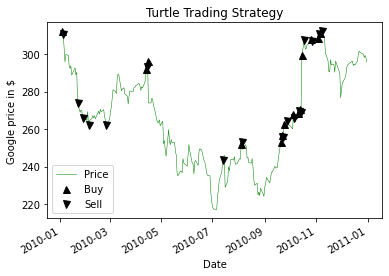

In [22]:
fig = plt.figure()
ax1 = fig.add_subplot(111, ylabel='Google price in $')
d2["Adj Close"].plot(ax=ax1, color='g', lw=.5)
ax1.plot(d1.loc[d1.orders== 1.0].index,
d2["Adj Close"][d1.orders == 1],
'^', markersize=7, color='k')
ax1.plot(d1.loc[d1.orders== -1.0].index,
d2["Adj Close"][d1.orders == -1],
'v', markersize=7, color='k')
plt.legend(["Price","Buy","Sell"])
plt.title("Turtle Trading Strategy")
plt.show()
